# k-means clustering using discrete signatures

## 1. Prep Data

### 1.1. Load Data
We load the signature data and the knot data

In [29]:
import pandas as pd

filename = f'../results/tables/signature_x1_L5_W2_20250425_184840.csv' # replace with desired signatures to use

# extract clustering parameters from filename
import re
match = re.search(r'L(\d+)_W(\d+)', filename)
if match:
    trunc_level = int(match.group(1))  # 15
    sig_weight = int(match.group(2))   # 2
else:
    raise ValueError("Filename format incorrect - missing L/W parameters")

print(f"trunc_level: {trunc_level}, sig_weight: {sig_weight}")

# Load the DataFrame from the CSV file
df = pd.read_csv(filename)

# Load the classification data
classification_df = pd.read_csv('../data/external/trefoil_list.csv')
classification_df = classification_df[classification_df['Representative'] != 'Other']

# Ensure the 'Landscape' column matches between the two DataFrames
df['Chain'] = df['Chain'].astype(str)  # Ensure the column type is consistent
classification_df['Chain'] = classification_df['Chain'].astype(str)



trunc_level: 5, sig_weight: 2


In [30]:
import pandas as pd

def safe_merge(df1, df2, merge_col='Chain', rep_col='Representative'):
    """
    Merges DataFrames while handling duplicate 'Representative' columns intelligently
    
    Args:
        df1, df2: DataFrames to merge
        merge_col: Column to merge on (default 'Chains')
        rep_col: Representative column name (default 'Representative')
    
    Returns:
        Merged DataFrame with a single Representative column
    """
    try:
        # Attempt merge with duplicate handling
        merged = df1.merge(df2, 
                          on=merge_col,
                          suffixes=('', '_y'))
        
        # Check if duplicate columns were created
        if f'{rep_col}_y' in merged.columns:
            # Verify values match if both columns exist
            if (merged[rep_col] == merged[f'{rep_col}_y']).all():
                merged = merged.drop(columns=[f'{rep_col}_y'])
            else:
                print("Warning: Representative values differ between DataFrames")
                # Keep both columns but rename for clarity
                merged = merged.rename(columns={
                    rep_col: f'{rep_col}_x',
                    f'{rep_col}_y': f'{rep_col}_y'
                })
        
        return merged
    
    except Exception as e:
        print(f"Merge failed: {str(e)}")
        # Fallback to simple merge if unexpected error occurs
        return df1.merge(df2, on=merge_col)



In [31]:
# Merge the DataFrames on the 'Landscape' column
try:
    merged_df = safe_merge(classification_df, df)
except Exception as e:
    print(f"Error during merge: {e}")
    merged_df = None

    
# Keep only rows where Representative is NOT 'other'
merged_df = merged_df[merged_df['Representative'] != 'Other']

# Select the columns corresponding to the signature
X = merged_df.drop(columns=['Landscape', 'Chain', 'Depth', 'Length', 'N-tail', 'C-tail', 'Representative'])



In [32]:
# Display the merged DataFrame
print(merged_df.head(2))

    Chain     Depth  Length  N-tail  C-tail Representative  Landscape  \
0  6i0j_A  0.001136     257      25       3         4qef_A        483   
1  6i0w_A  0.001382     258      23       4         4qef_A        484   

       [11]      [12]      [13]  ...    [4][2]    [4][3]    [4][4]    [4][5]  \
0  0.003772  0.003312  0.003236  ...  0.198469  0.148717 -0.001836 -0.332533   
1  0.004079  0.003514  0.003087  ...  0.583205  0.082766 -0.001815 -0.251816   

   [5]    [5][1]    [5][2]    [5][3]    [5][4]    [5][5]  
0  0.0  0.297666  0.399285  0.399664  0.330104 -0.001805  
1  0.0  0.723839  0.689146  0.292050  0.249085 -0.001796  

[2 rows x 52 columns]


In [5]:
rep_list = merged_df['Representative'].unique()
len(rep_list)

9

### 1.2. Hyperparameters

In [6]:
n_clusters = len(rep_list) # Adjust if you don't want the same number of clusters as the number of rep classes
var_threshold = 0 # Adjust based on section 2. Ror the paper this was set at 0

### 1.3. Dimensionality reduction: ignoring features with low variance

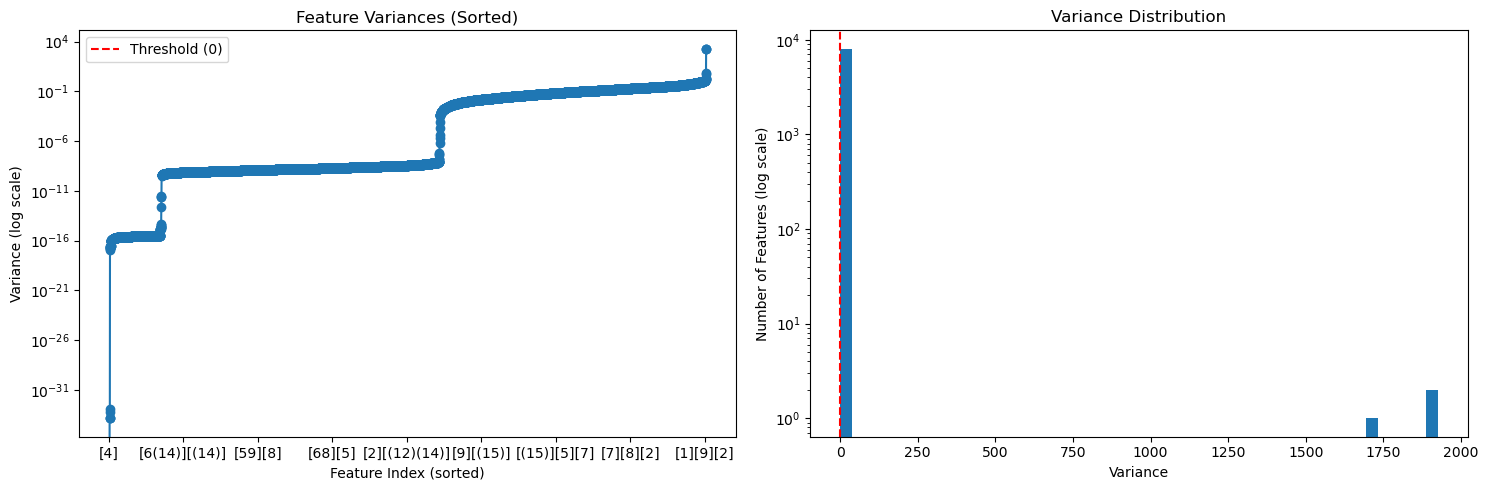

Variance Statistics:
count    8.021000e+03
mean     7.660227e-01
std      3.578259e+01
min      0.000000e+00
10%      5.839270e-10
25%      1.248140e-09
50%      3.542349e-09
75%      7.012600e-02
90%      2.380827e-01
max      1.924799e+03
dtype: float64

Features below variance thresholds:
1e-06: 4441 features (55.4%)
1e-04: 4445 features (55.4%)
1e-03: 4469 features (55.7%)
1e-02: 4832 features (60.2%)
1e-01: 6328 features (78.9%)

10 lowest-variance features:
[4]       0.0
[(15)]    0.0
[(14)]    0.0
[(10)]    0.0
[(12)]    0.0
[9]       0.0
[(13)]    0.0
[8]       0.0
[(11)]    0.0
[1]       0.0
dtype: float64

Original features: 8021
Features kept: 8011
Features removed: 10


In [7]:
# Plot variance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

# 1. Calculate feature variances
variances = X.var(axis=0).sort_values()  # Series of variances sorted low to high

# 2. Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Ordered variance plot
plt.subplot(1, 2, 1)
variances.plot(logy=True, marker='o', title='Feature Variances (Sorted)')
plt.axhline(y=var_threshold, color='r', linestyle='--', label=f'Threshold ({var_threshold})')
plt.ylabel('Variance (log scale)')
plt.xlabel('Feature Index (sorted)')
plt.legend()

# Need to adjust plaot 2!!
# Plot 2: Variance distribution
plt.subplot(1, 2, 2)
plt.hist(variances, bins=50, log=True)
plt.axvline(x=var_threshold, color='r', linestyle='--')
plt.title('Variance Distribution')
plt.xlabel('Variance')
plt.ylabel('Number of Features (log scale)')

plt.tight_layout()
plt.show()

# 3. Variance statistics
print("Variance Statistics:")
print(variances.describe(percentiles=[.1, .25, .5, .75, .9]))

# 4. Count features below potential thresholds
thresholds = [1e-6, 1e-4, 1e-3, 0.01, 0.1]
print("\nFeatures below variance thresholds:")
for thresh in thresholds:
    n_below = (variances < thresh).sum()
    print(f"{thresh:.0e}: {n_below} features ({n_below/len(variances):.1%})")

# 5. Show lowest-variance features
print("\n10 lowest-variance features:")
print(variances.head(10))

# 6. Apply your chosen threshold
selector = VarianceThreshold(threshold=var_threshold)
X_filtered = selector.fit_transform(X)

# Create new DataFrame with kept features
kept_features = X.columns[selector.get_support()]
df_filtered = pd.DataFrame(X_filtered, columns=kept_features)

print(f"\nOriginal features: {X.shape[1]}")
print(f"Features kept: {df_filtered.shape[1]}")
print(f"Features removed: {X.shape[1] - df_filtered.shape[1]}")

In [8]:
# Update your signatures after discrding low variance features
X= df_filtered
# X.head()

### 1.4. Standardize the data

In [9]:
from sklearn.preprocessing import StandardScaler,  MinMaxScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the data
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Display the standardized DataFrame
# print(X_standardized)

## 2. Perform k-means on prepped data

In [10]:
# k-mean on the standardized data
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # For dimensionality reduction

# Perform k-Means clustering
kmeans = KMeans(n_clusters, random_state=42)  # Choose the number of clusters
clusters_std = kmeans.fit_predict(X_standardized)

# Add the cluster labels to the DataFrame
merged_df['Cluster_standardized'] = clusters_std

## 3. Compare k-means and classification by representative (sequence similarity) 
We now check compatibility between the k-means clustering(s) and the classification in terms of the knot representative

In [11]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Extract the ground truth labels and cluster labels
true_labels = merged_df['Representative']
cluster_std_labels = merged_df['Cluster_standardized'].astype(str)

print(f"Variance Threshold: {var_threshold}")
# Compute the Adjusted Rand Index (ARI)
ari_std = adjusted_rand_score(true_labels, cluster_std_labels)
print(f"Adjusted Rand Index (ARI) [Standardized data]: {ari_std:.2f}")

# Compute the Normalized Mutual Information (NMI)
nmi_std = normalized_mutual_info_score(true_labels, cluster_std_labels)
print(f"Normalized Mutual Information (NMI): {nmi_std:.2f}")

Variance Threshold: 0
Adjusted Rand Index (ARI) [Standardized data]: 0.95
Normalized Mutual Information (NMI): 0.87


### 3.1. [Optional] Save the large dataframe

In [12]:
# Optional: save the large data frame
from datetime import datetime

# Human-readable date (e.g., "21May2024")
date_str = datetime.now().strftime("%d%b%Y")  # %b = abbreviated month (Jan, Feb, etc.)

# Compact metrics notation (adjust precision as needed)
metrics_str = f"A{ari_std:.2f}_N{nmi_std:.2f}"

# Final filename
filename = (
    f"../results/tables/clustering_L{trunc_level}_W{sig_weight}_V{var_threshold:.0e}_"
    f"ARIstd{ari_std:.2f}_"
    f"NMIstd{nmi_std:.2f}_"
    f"{date_str}.csv"
)
merged_df.to_csv(filename, index=False)
print(f"Saved: {filename}")

Saved: ../results/tables/clustering_L15_W3_V0e+00_ARIstd0.95_NMIstd0.87_28Apr2025.csv


### 3.2 Log results in Master dataframe

In [13]:
# Initialize empty DataFrame (if starting fresh)
# columns = [
#     'variance_threshold', 'truncation_level', 'signature_weight', 'n_clusters',
#     'ARI_standardized', 'ARI_normalized', 'NMI_standardized', 'NMI_normalized'
# ]
# master_results_df = pd.DataFrame(columns=columns)

# # Add first entry
# new_entry = {
#     'variance_threshold': -1,
#     'truncation_level': 4,
#     'signature_weight': 2,
#     'n_clusters': 6,
#     'ARI_standardized': 0.38,
#     'NMI_standardized': 0.30,
# }
# master_results_df = pd.concat([master_results_df, pd.DataFrame([new_entry])], ignore_index=True)

In [14]:
# Load DataFrame if continuing to add results
try:
    master_results_df = pd.read_csv('../results/master_results_comparison_kmeans_sig_V_representatives_x1_dropOther.csv', encoding='utf-8')
    print("Loaded successfully! Shape:", master_results_df.shape)
except FileNotFoundError:
    print("File not found!")
except Exception as e:
    print("Error:", str(e))

Loaded successfully! Shape: (9, 6)


In [15]:
# Verify load
# print(master_results_df.head())  # First 5 rows
# print(master_results_df.info())  # Data types and memory usage
master_results_df

,variance_threshold,truncation_level,signature_weight,n_clusters,ARI_standardized,NMI_standardized
0,0.000000e+00,10.0,2.0,9.0,0.455478,0.634319
1,0.000000e+00,10.0,2.0,7.0,0.867993,0.747505
2,0.000000e+00,10.0,2.0,5.0,0.746163,0.704894
3,0.000000e+00,10.0,2.0,8.0,0.468378,0.634098
4,0.000000e+00,10.0,2.0,6.0,0.731497,0.683264
5,0.000000e+00,10.0,2.0,15.0,0.370048,0.635436
6,0.000000e+00,5.0,3.0,8.0,0.586025,0.527567
7,1.000000e-09,5.0,3.0,9.0,0.496869,0.482446
8,0.000000e+00,15.0,2.0,9.0,0.538607,0.738347


In [16]:
# Add next entry
master_results_df.loc[len(master_results_df)] = [
    var_threshold,  # variance_threshold
    trunc_level,     # truncation_level
    sig_weight,     # signature_weight
    n_clusters,    # n_clusters
    ari_std,  # ARI_standardized
    nmi_std,  # NMI_standardized
]

In [17]:
master_results_df

,variance_threshold,truncation_level,signature_weight,n_clusters,ARI_standardized,NMI_standardized
0,0.000000e+00,10.0,2.0,9.0,0.455478,0.634319
1,0.000000e+00,10.0,2.0,7.0,0.867993,0.747505
2,0.000000e+00,10.0,2.0,5.0,0.746163,0.704894
3,0.000000e+00,10.0,2.0,8.0,0.468378,0.634098
4,0.000000e+00,10.0,2.0,6.0,0.731497,0.683264
5,0.000000e+00,10.0,2.0,15.0,0.370048,0.635436
6,0.000000e+00,5.0,3.0,8.0,0.586025,0.527567
7,1.000000e-09,5.0,3.0,9.0,0.496869,0.482446
8,0.000000e+00,15.0,2.0,9.0,0.538607,0.738347
9,0.000000e+00,15.0,3.0,9.0,0.949612,0.869305


In [21]:
# Save results

# Generate the filename
filename = f'../results/tables/master_results_comparison_kmeans_sig_V_representatives_x1_dropOther.csv'

# Save the DataFrame
master_results_df.to_csv(filename, index=False)

print(f"Data saved to {filename}")

Data saved to ../results/tables/master_results_comparison_kmeans_sig_V_representatives_x1_dropOther.csv


## 4. Visualize results

### 4.1. Histogram

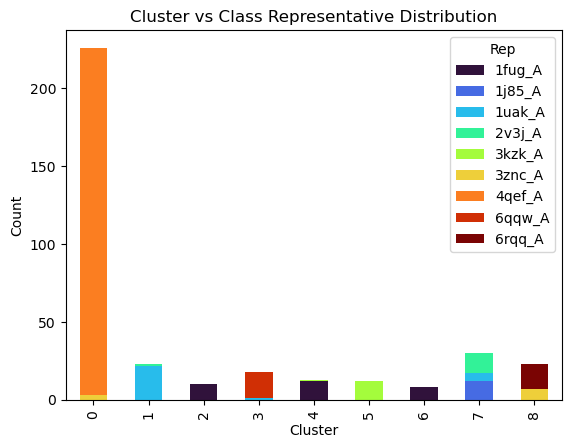

In [19]:
import seaborn as sns

# Create a cross-tabulation of clusters and classes
cross_tab = pd.crosstab(merged_df['Cluster_standardized'], merged_df['Representative'])

# Plot the stacked bar plot
cross_tab.plot(kind='bar', stacked=True, colormap='turbo')
plt.title("Cluster vs Class Representative Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Rep")
plt.show()

In [20]:
# Save the figure
hist_figname= f'../results/fig/hplot_cluster_v_rep_x1_L{trunc_level}_W{sig_weight}_thresh_{var_threshold}_Clusters_{n_clusters}.png'
plt.savefig(hist_figname, dpi=300, bbox_inches='tight')
plt.close()  # Prevents duplicate display in notebook

### 4.2. Format the results table for better display

In [23]:
Y = master_results_df.drop(columns=['variance_threshold'])
Y = Y.rename(columns={'ARI_standardized': 'ARI', 'NMI_standardized': 'NMI'})
new_order = ['truncation_level', 'signature_weight', 'n_clusters', 
             'ARI', 'NMI']

In [24]:
def highlight_top_rows(row):
    return ['background-color: yellow' if row['ARI'] > 0.9 else '' for _ in row]


In [25]:
# Style integers as integers, floats with 2 decimals
styled_df = Y.sort_values('ARI', ascending=False).style.format({
    'truncation_level': '{:.0f}',         # No decimals for integers
    'signature_weight' : '{:.0f}',
    'n_clusters' : '{:.0f}',
    'ARI': '{:.3f}',         # 2 decimals for metrics
    'NMI': '{:.3f}'
}).apply(highlight_top_rows, axis=1).set_properties(**{
    'border': '1px solid black',
    'text-align': 'center'
}).set_table_styles([
    {  # Style for headers
        'selector': 'th',
        'props': [
            ('background-color', '#404040'),
            ('color', 'white'),
            ('width', '100px')  # Fixed width for all headers
        ]
    },
    {  # Style for data cells (to match headers)
        'selector': 'td',
        'props': [
            ('width', '100px')  # Same width as headers
        ]
    }
])

In [26]:
styled_df = styled_df.apply(highlight_top_rows, axis=1)
styled_df

,truncation_level,signature_weight,n_clusters,ARI,NMI
9,15,3,9,0.950,0.869
1,10,2,7,0.868,0.748
2,10,2,5,0.746,0.705
4,10,2,6,0.731,0.683
6,5,3,8,0.586,0.528
8,15,2,9,0.539,0.738
7,5,3,9,0.497,0.482
3,10,2,8,0.468,0.634
0,10,2,9,0.455,0.634
5,10,2,15,0.370,0.635
